# Style transfer

### Import

In [2]:
# tensorflow version >= 2.0.0-beta1
import tensorflow as tf
# system
import time
from IPython.display import clear_output
# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# pix2pix
from tensorflow_examples.models.pix2pix import pix2pix

print('Tensorflow version: ', end='')
print(tf.__version__)

Tensorflow version: 2.0.0-beta1


### Datasets

In [3]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [4]:
# decoding the image
def decode(image):
  # convert the compressed string to a 3D uint8 tensor
  image = tf.image.decode_jpeg(image, channels=3)
  # use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize the image to the desired size.
  return image

In [5]:
# resizing the image
def resize(image):
  # resize the image to the desired size.
  return tf.image.resize(image, [286, 286])

In [6]:
# random cropping the images
def random_crop(image):
  cropped_image = tf.image.random_crop(image, size=[256, 256, 3])
  return cropped_image

In [7]:
# getting label for the path
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, '/')
  # the second to last is the class-directory
  dir = parts[-2]
  return dir == "trainA" or dir == "testA"

In [8]:
# preprocess the images
def preprocess(path):
  # label for the path
  label = get_label(path)
  # load the raw data from the file as a string
  image = tf.io.read_file(path)
  # decoding
  image = decode(image)
  # resizing to 286 x 286 x 3
  image = resize(image)
  # random cropping
  image = random_crop(image)
  return image, label

In [9]:
# preprocess the images without normalizing
def preprocess_without_norm(path):
  # label for the path
  label = get_label(path)
  # load the raw data from the file as a string
  image = tf.io.read_file(path)
  # decoding
  image = decode(image)
  return image, label

In [10]:
# buffer size
BUFFER_SIZE = 1000

# creating datasets
train_A = tf.data.Dataset.list_files('vangogh2photo/trainA/*.jpg').map(preprocess).cache().shuffle(BUFFER_SIZE).batch(1)
train_B = tf.data.Dataset.list_files('vangogh2photo/trainB/*.jpg').map(preprocess).cache().shuffle(BUFFER_SIZE).batch(1)
test_A = tf.data.Dataset.list_files('vangogh2photo/testA/*.jpg').map(preprocess).cache().shuffle(BUFFER_SIZE).batch(1)
test_B = tf.data.Dataset.list_files('vangogh2photo/testB/*.jpg').map(preprocess).cache().shuffle(BUFFER_SIZE).batch(1)

# train sample A
sample_train_A = next(iter(train_A))
# train sample B
sample_train_B = next(iter(train_B))

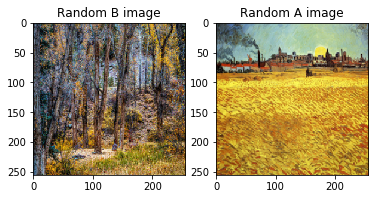

In [11]:
# showing random image from train B dataset
for image, label in train_B.take(1):
    plt.subplot(121)
    plt.title('Random B image')
    plt.imshow(image[0])

# showing random image from train A dataset
for image, label in train_A.take(1):
    plt.subplot(122)
    plt.title('Random A image')
    plt.imshow(image[0])

### Generators and discriminators

In [12]:
OUTPUT_CHANNELS = 3

# A to B generator
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
# B to A generator
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# A discriminator
discriminator_a = pix2pix.discriminator(norm_type='instancenorm', target=False)
# B discriminator
discriminator_b = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


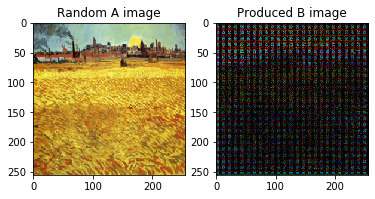

In [13]:
# example A to B
to_b = generator_g(sample_train_A)

# showing random A image
plt.subplot(121)
plt.title('Random A image')
plt.imshow(sample_train_A[0][0])

# showing produced B image
plt.subplot(122)
plt.title('Produced B image')
plt.imshow(to_b[0])

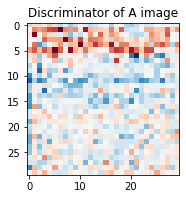

In [15]:
# showing discriminator of A image
plt.subplot(122)
plt.title('Discriminator of A image')
plt.imshow(discriminator_a(sample_train_A)[0, ..., -1], cmap='RdBu_r')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


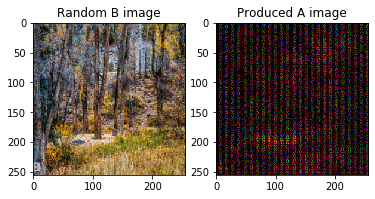

In [16]:
# example B to A
to_a = generator_f(sample_train_B)

# showing random B image
plt.subplot(121)
plt.title('Random B image')
plt.imshow(sample_train_B[0][0])

# showing produced A image
plt.subplot(122)
plt.title('Produced A image')
plt.imshow(to_a[0])

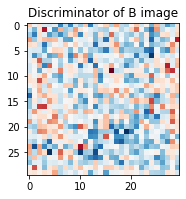

In [17]:
# showing discriminator of B image
plt.subplot(121)
plt.title('Discriminator of B image')
plt.imshow(discriminator_b(sample_train_B)[0, ..., -1], cmap='RdBu_r')

### Loss functions

In [18]:
LAMBDA = 10

# cross-entropy loss with binary label
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
# calculate discriminator loss
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  # return mean value
  return total_disc_loss * 0.5

In [20]:
# calculate generator loss
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [21]:
# calculate cycle loss
def cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

In [22]:
# calculate identity loss
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [23]:
# generator optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# discriminator optimizers
discriminator_a_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_b_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Training

In [24]:
EPOCHS = 2

In [25]:
@tf.function
def train_step(real_a, real_b):
  with tf.GradientTape(persistent=True) as tape:
    # generator values
    fake_b = generator_g(real_a, training=True)
    cycled_a = generator_f(fake_b, training=True)
    fake_a = generator_f(real_b, training=True)
    cycled_b = generator_g(fake_a, training=True)

    # same_a and same_b used for identity loss
    same_a = generator_f(real_a, training=True)
    same_b = generator_g(real_b, training=True)

    # discriminator values
    disc_real_a = discriminator_a(real_a, training=True)
    disc_real_b = discriminator_b(real_b, training=True)
    disc_fake_a = discriminator_a(fake_a, training=True)
    disc_fake_b = discriminator_b(fake_b, training=True)

    # calculate generator loss
    gen_g_loss = generator_loss(disc_fake_b)
    gen_f_loss = generator_loss(disc_fake_a)
    
    # total cycle loss
    total_cycle_loss = cycle_loss(real_a, cycled_a) + cycle_loss(real_b, cycled_b)
    
    # total generator loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_b, same_b)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_a, same_a)

    # discriminator loss
    disc_a_loss = discriminator_loss(disc_real_a, disc_fake_a)
    disc_b_loss = discriminator_loss(disc_real_b, disc_fake_b)
  
  # calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  discriminator_a_gradients = tape.gradient(disc_a_loss, 
                                            discriminator_a.trainable_variables)
  discriminator_b_gradients = tape.gradient(disc_b_loss, 
                                            discriminator_b.trainable_variables)
  
  # apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  discriminator_a_optimizer.apply_gradients(zip(discriminator_a_gradients,
                                                discriminator_a.trainable_variables))
  
  discriminator_b_optimizer.apply_gradients(zip(discriminator_b_gradients,
                                                discriminator_b.trainable_variables))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


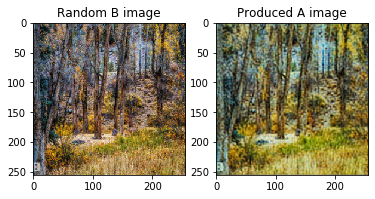

Time taken for epoch 2 is 676.0628917217255 sec



In [26]:
# train loop
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  # train on each pair from train dataset
  for image_a, image_b in tf.data.Dataset.zip((train_A, train_B)):
    train_step(image_a[0], image_b[0])
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  # clearing output
  clear_output(wait=True)
  # trained example A to B
  to_a = generator_f(sample_train_B)
  # showing random B image
  plt.subplot(121)
  plt.title('Random B image')
  plt.imshow(sample_train_B[0][0])
  # showing produced A image
  plt.subplot(122)
  plt.title('Produced A image')
  plt.imshow(to_a[0])
  plt.show()

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

### Test

In [ ]:
# run the trained model on the A test dataset
for image in test_A.take(30):
    to_b = generator_g(image)
    # showing random B image
    plt.subplot(121)
    plt.title('Random A image')
    plt.imshow(image[0][0])
    # showing produced A image
    plt.subplot(122)
    plt.title('Produced B image')
    plt.imshow(to_b[0])
    plt.show()

In [ ]:
# run the trained model on the B test dataset
for image in test_B.take(30):
    to_a = generator_f(image)
    # showing random B image
    plt.subplot(121)
    plt.title('Random B image')
    plt.imshow(image[0][0])
    # showing produced A image
    plt.subplot(122)
    plt.title('Produced A image')
    plt.imshow(to_a[0])
    plt.show()

In [ ]:
# export all BA examples
i = 1
for image in test_B.take(751):
    to_a = generator_f(image)
    plt.title("Input B image #{}".format(i))
    plt.imshow(image[0][0])
    plt.savefig("b_a_processing/{}_b.png".format(i))
    plt.title("Produced A image #{}".format(i))
    plt.imshow(to_a[0])
    plt.savefig("b_a_processing/{}_a.png".format(i))
    i += 1

In [ ]:
# export all AB examples
i = 1
for image in test_A.take(400):
    to_b = generator_g(image)
    plt.title("Input A image #{}".format(i))
    plt.imshow(image[0][0])
    plt.savefig("a_b_processing/{}_a.png".format(i))
    plt.title("Produced B image #{}".format(i))
    plt.imshow(to_b[0])
    plt.savefig("a_b_processing/{}_b.png".format(i))
    i += 1

### Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
# restoring the latest checkpoint if exists
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored')

In [ ]:
# saving checkpoint
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint at {}'.format(ckpt_save_path))